In [2]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [3]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import multiprocessing as mp
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from IPython.display import HTML, display, Markdown
import umap

from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category20
from bokeh.transform import factor_cmap

import scanpy as sc

from react_scatter_board import ReactScatterBoard

from maayanlab_bioinformatics.normalization import log2_normalize, filter_by_var
from scipy.stats import zscore
import qnorm

output_notebook() #allow bokeh plot show on the notebook

Loading BokehJS ...

In [4]:
%%appyter hide_code_exec
{% do SectionField(
    name='Data_Section',
    title='Load Your Data',
    subtitle='Load your metadata and data matrix in comma/tab separated formats. Genes should be in rows and samples shoud be in columns.',
    img='load.png'
    
) %}


{% do SectionField(
    name='Visualization_Section',
    title='Select Visualization Parameters',
    subtitle='',
    img='select.png'
    
) %}

In [5]:
%%appyter code_exec
{% set rnaseq_data_filename = FileField(
    name='rnaseq_data_filename', 
    label='RNA-seq data file (.csv or .txt)', 
    default='mouse_brain_cells_gene_counts.csv',
    examples={'mouse_brain_cells_gene_counts.csv': "https://appyters.maayanlab.cloud/storage/dimensionality_reduction_visualization/mouse_brain_cells_gene_counts.csv"}, 
    description='Upload RNA-seq data matrix as comma seperated or tab seperated format. The index of the dataset are cells, the columns are samples.', 
    section='Data_Section')

%}

{% set has_meta_data = BoolField(
    name='has_meta_data', 
    label='Has metadata file?',
    default='false',
    description='Having metadata makes plot to have color', 
    section='Data_Section') 
%}

{% set meta_data_filename = FileField(
    name='meta_data_filename', 
    label='Metadata file (.csv or .txt)', 
    default='mouse_brain_cells_metadata.csv',

    examples={'mouse_brain_cells_metadata.csv': "https://appyters.maayanlab.cloud/storage/dimensionality_reduction_visualization/mouse_brain_cells_metadata.csv"}, 
    description='Upload metadata as two-column comma seperated or tab seperated format. One column contains sample ids and the other column contains sample labels', 
    section='Data_Section')

%}

{% set meta_class_column_name = StringField(
    name='meta_class_column_name', 
    label='Class column name in metadata', 
    default='cell_ontology_class', 
    description='One of the column names in metadata', 
    section='Data_Section')
%}


In [6]:
%%appyter code_exec
{% set need_normalize = BoolField(
    name='need_normalize', 
    label='Normalization?',
    default='false',
    description='It is recommended to upload normalized data for better visualization performance', 
    section='Visualization_Section') 
%}

{% set need_leiden = BoolField(
    name='need_leiden', 
    label='Leiden graph for clustering?',
    default='false',
    description='Leiden graph is for coloring clusters when you do not have metadata', 
    section='Visualization_Section') 
%}

{% set plot_3D = ChoiceField(
    name='3D_plot', 
    label='3D plots?', 
    choices = {'2D': '2D', '3D': '3D', 'All':'All'},
    default='All', 
    description='Choose to have 2D, 3D, or all plots', 
    section='Visualization_Section')
%}

{% set visualization_method = ChoiceField(
    name='visualization_method', 
    label='Visualization Methods', 
    choices = {'All': 'All','PCA': 'PCA', 'UMAP': 'UMAP', 't-SNE': 't-SNE'},
    default='All', 
    description='Select a visualization method for perform all methods', 
    section='Visualization_Section')
%}


In [7]:
%%appyter code_exec
rnaseq_data_filename = {{rnaseq_data_filename}}
meta_data_filename = {{meta_data_filename}}
meta_class_column_name = {{meta_class_column_name}}
has_matadata = {{has_meta_data}}


need_normalize = {{need_normalize}}
need_leiden = {{need_leiden}}
plot_3D = "{{plot_3D}}"
clustering_topk = 50
method = "{{visualization_method}}"


```python
rnaseq_data_filename = 'mouse_brain_cells_gene_counts.csv'
meta_data_filename = 'mouse_brain_cells_metadata.csv'
meta_class_column_name = 'cell_ontology_class'
has_matadata = True
need_normalize = True
plot_3D = "All"
clustering_topk = 50
method = "All"
```

# PCA, t-SNE, and UMAP Appyter

This Appyter [1] loads data in a matrix format, it then performs dimensionality reduction algorithms on the data; and then visualizes the dimensionality reduced data with with static and interactive 2D and 3D PCA [2], t-SNE [3], and UMAP [4] plots.  

## PCA
Principal Component Analysis (PCA) [2] is a statistical technique ussed to identify global patterns in high-dimensional datasets. It is commonly used to explore the similarity of biological samples in omics datasets. To perform PCA, variable values are transformed into Principal Components (PCs), a set of linearly orthogonal features which represent the most relevant sources of variance in the data. The top PCs subsequently visualized using a scatter plot for each variable to estimate similarity and differences between the variables in higher dimensions.


## t-SNE
t-distributed stochastic neighbor embedding (t-SNE) [3] is a statistical method used to identify global patterns in high-dimensional datasets. It is a non-linear Dimensionality reduction technique, and it embeds the points from a higher dimension to a lower dimension trying to preserve the neighborhood of that point. It then provides each datapoint a location in a two or three-dimensional space visualized using a scatter plot.

## UMAP
Uniform Manifold Approximation and Projection (UMAP) [4] is a statistical method used to identify global patterns in high-dimensional datasets. It creates a graph that accurately reflects the topology of the true high dimensional graph. It then calculates the weight for edges of this graph and builds the low dimensional graph.

## Leiden's Algorithm
Leiden algorithm [5] identifies well-connected clusters in networks. In this procedure, the appyter takes into account both modalities of the data by integrating connectivity graphs generated from each modality (ref https://scanpy-tutorials.readthedocs.io/en/multiomics/cite-seq/pbmc5k.html#Clustering). It visualizes the samples colored by clusters.

## Analysis Overview
The input data matrix that has been normalized first undergoes dimensionality reduction using PCA [2], t-SNE [3], and UMAP [4] with the Python library. Columns are then clustered based on their most-associated highly-variable variables and metadata features. Clusters are visualized using the Bokeh package [6] for the 2D plots, and the React-Scatter-Board package [7] developed by the Ma'ayan lab for interactive visualization of the 3D plots. In addition, user may select to upload data without metadata and use Leiden's algorithm [5] to visualize clusters.

# Read Data

In [19]:
# rnaseq_data_filename = 'RNAseq.ENSG.tpm'

In [ ]:
# check if filename extension can be read in Leiden graph

if need_leiden:
    try:
        pbmc = sc.read(rnaseq_data_filename)
    except:
        raise Exception("Error! Incorrect filename extension for Leiden graph. Available extensions are 'csv', 'txt','tsv'.")

In [8]:
def load_file(filename, **kwargs):
    if filename.endswith(".csv"):
        temp_df = pd.read_csv(filename, **kwargs).sort_index()
    elif filename.endswith(".txt") or filename.endswith(".tsv") or filename.endswith(".tpm"):
        temp_df = pd.read_csv(filename, sep="\t", **kwargs).sort_index()
    else:
        raise Exception('Error! Incorrect format. Please load file in txt, tsv, tpm, or csv format')
    
    return temp_df

expr_df = load_file(rnaseq_data_filename, index_col=0)

if has_matadata:
    meta_df = load_file(meta_data_filename)
    assert meta_class_column_name in meta_df.columns, f"Error! Column '{meta_class_column_name}' is not in metadata"
    meta_df.head()

In [9]:
expr_df.head()

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,...,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,-0.08093,0.7856,1.334,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,1.567
A1.B003728.3_56_F.1.1,-0.08093,-1.4840,-0.576,-0.2727,-0.4153,1.8350,-0.4692,-0.03146,-0.6035,-1.021,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,-0.681
A1.MAA000560.3_10_M.1.1,-0.08093,0.6300,-0.576,-0.2727,-0.4153,-0.2084,-0.4692,-0.03146,-0.6035,1.253,...,1.3150,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,2.072,-0.5654,-0.04385,1.260
A1.MAA000564.3_10_M.1.1,-0.08093,0.3809,1.782,-0.2727,-0.4153,1.0300,-0.4692,-0.03146,1.2640,-1.021,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,2.3900,-0.553,0.1697,-0.04385,-0.681
A1.MAA000923.3_9_M.1.1,-0.08093,0.5654,-0.576,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021,...,-0.7227,-0.2145,-0.1927,-0.4163,2.3180,-0.5913,-0.553,-0.5654,-0.04385,-0.681


In [10]:
# check if data have been loaded correctly
try:
    pca = PCA(n_components=clustering_topk)
    pca.fit_transform(expr_df)
except:
    raise Exception("Error! Incorrect format. Please check if the data have been read/seperated correctly.")

# Normalize Data¶

In [10]:
if need_normalize:
    df_data_norm = log2_normalize(expr_df, offset=1)
    df_data_norm = qnorm.quantile_normalize(df_data_norm, axis=1)
    df_data_norm = filter_by_var(df_data_norm,top_n = 2500)

    #convert to zscores
    expr_df = pd.DataFrame(zscore(df_data_norm, axis=1), index=df_data_norm.index, columns=df_data_norm.columns)

    if has_matadata:
        meta_df = meta_df[meta_df["cell"].isin(df_data_norm.index)].reset_index()

/Users/panjuncheng/Desktop/MS-work/my-first-appyter/venv/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
/Users/panjuncheng/Desktop/MS-work/my-first-appyter/venv/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


In [ ]:
expr_df.head()

In [ ]:
# check if data have been normalized correctly
try:
    pca = PCA(n_components=clustering_topk)
    pca.fit_transform(expr_df)
except:
    raise Exception("Error in normalization! Try to unselect normalization field.")

# Visualize Samples

In [11]:
def diplay_caption(counter, caption):
    display(Markdown("*Figure {}. {}*".format(counter, caption)))
    
def create_df(transformed_data, is3D = False):
    scaler = StandardScaler().fit(transformed_data)
    X_scaled = scaler.transform(transformed_data)
    df = pd.DataFrame()
    if has_matadata:
        df["y"] = meta_df[meta_class_column_name]
    else:
        df["y"] = expr_df.index

    df["pc1"] = X_scaled[:,0]
    df["pc2"] = X_scaled[:,1]
    df["pc3"] = X_scaled[:,2]
    
    if is3D:
        return [dict(x=r['pc1'], y=r['pc2'], z=r['pc3'],Type=r['y'], opacity=0.7) for _, r in df.iterrows()]
    else :
        return df

In [12]:
def display_PCA_variance(pca):
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    source = ColumnDataSource(data=dict(
        x=range(len(cumulative_variance)),
        y=cumulative_variance,
    ))

    TOOLTIPS = [
        ("index", "$index"),
        ("(x,y)", "($x, $y)"),
    ]

    p = figure(width=500, height=400, tooltips=TOOLTIPS, x_axis_label='principal components', 
               y_axis_label='cumulative proportion of variance')
    p.line('x', 'y', source=source)
    p.output_backend = "svg"
    return p

def model_PCA_feature():
    pca = PCA(n_components=3)
    transformed_df = pca.fit_transform(expr_df)
    return transformed_df

def model_t_SNE_feature():
    n_jobs=mp.cpu_count()
    tsne = TSNE(n_jobs = n_jobs, n_components=3)
    transformed_df = tsne.fit_transform(expr_df) 
    return transformed_df

def model_Umap_feature():
    umap_model = umap.UMAP(n_components=3)
    transformed_df = umap_model.fit_transform(expr_df)
    return transformed_df

def leiden_visualization():
    pbmc = sc.read(rnaseq_data_filename)
    pbmc.var_names_make_unique()
    pbmc.layers["counts"] = pbmc.X.copy()
    sc.pp.filter_genes(pbmc, min_counts=1)

    rna = pbmc.copy()
    
    sc.pp.pca(rna, n_comps=20)
    sc.pp.neighbors(rna, n_neighbors=30)  
    sc.tl.leiden(rna, key_added="leiden")
    
    rna.obsp["rna_connectivities"] = rna.obsp["connectivities"].copy()
    sc.tl.umap(rna)
    sc.pl.umap(rna, color="leiden", size=10)

def interactive_circle_plot(input_df, x_lab, y_lab):
    source = ColumnDataSource(data=dict(
        x=input_df["pc1"],
        y=input_df["pc2"],
        cell=input_df["y"],
    ))

    TOOLTIPS = [
        ("index", "$index"),
        ("(x,y)", "($x, $y)"),
        ("cell", "@cell"),
    ]

    p = figure(width=800, height=400, tooltips=TOOLTIPS,x_axis_label=x_lab, y_axis_label=y_lab)
    
    if has_matadata:
        color = factor_cmap('cell', palette=Category20[20], factors=input_df["y"].unique())
        p.circle('x', 'y', size=3, source=source, legend_group="cell",
                 fill_color= color, line_color=color)

        p.add_layout(p.legend[0], 'right')
    else:
        p.circle('x', 'y', size=3, source=source)
        
    p.output_backend = "svg"
    return p

```python
counter = 1
leiden_visualization()
counter += 1
caption = "Leiden 2D scatter plot. Each point presents a column from the input data matrix."
diplay_caption(counter, caption)
```

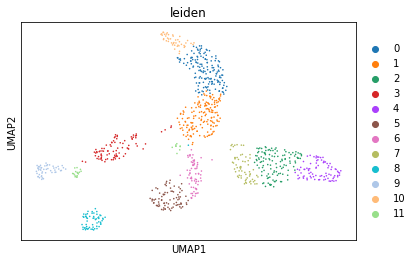

*Figure 2. Leiden 2D scatter plot. Each point presents a column from the input data matrix.*

In [16]:
counter = 1

if need_leiden:
    leiden_visualization()
    counter += 1

    caption = "Leiden 2D scatter plot. Each point presents a column from the input data matrix."

    diplay_caption(counter, caption)

In [17]:
%%appyter code_exec

{% if (plot_3D.value == "2D" or plot_3D.value == "All") and (visualization_method.value == "All" or visualization_method.value == "PCA") %}
pca = PCA(n_components=clustering_topk)
transformed_pca = pca.fit_transform(expr_df)

p1 = display_PCA_variance(pca)    
p2 = interactive_circle_plot(create_df(transformed_pca), "PC-1", "PC-2")

show(p1)
caption = "Cumulative proportion of variance explained as a function of the number of principal components. If the cumulative proportion of variance equal to 1, it explains 100% of the variance within the data."
diplay_caption(counter, caption)

counter += 1

show(p2)
if has_matadata:
    caption = "PCA 2D scatter plot when the select feature to highlight is {}. Each point presents a column from the input data matrix.".format(meta_class_column_name)
else:
    caption = "PCA 2D scatter plot. Each point presents a column from the input data matrix."
diplay_caption(counter, caption)
{% endif %}

{% if (plot_3D.value == "2D" or plot_3D.value == "All") and (visualization_method.value == "All" or visualization_method.value == "t-SNE") %}
transformed_df = model_t_SNE_feature()
p = interactive_circle_plot(create_df(transformed_df), "t-SNE-1", "t-SNE-2")
counter += 1
show(p)

if has_matadata:
    caption = "t-SNE 2D scatter plot when the select feature to highlight is {}. Each point presents a column from the input data matrix.".format(meta_class_column_name)
else:
    caption = "t-SNE 2D scatter plot. Each point presents a column from the input data matrix."

diplay_caption(counter, caption)
{% endif %}

{% if (plot_3D.value == "2D" or plot_3D.value == "All") and (visualization_method.value == "All" or visualization_method.value == "UMAP") %}
transformed_df = model_Umap_feature()
p = interactive_circle_plot(create_df(transformed_df),"UMAP-1","UMAP-2")
counter += 1
show(p)

if has_matadata:
    caption = "UMAP 2D scatter plot when the select feature to highlight is {}. Each point presents a column from the input data matrix.".format(meta_class_column_name)
else:
    caption = "UMAP 2D scatter plot. Each point presents a column from the input data matrix."

diplay_caption(counter, caption)
{% endif %}

```python
pca = PCA(n_components=clustering_topk)
transformed_pca = pca.fit_transform(expr_df)
p1 = display_PCA_variance(pca)
p2 = interactive_circle_plot(create_df(transformed_pca), "PC-1", "PC-2")
show(p1)
caption = "Cumulative proportion of variance explained as a function of the number of principal components. If the cumulative proportion of variance equal to 1, it explains 100% of the variance within the data."
diplay_caption(counter, caption)
counter += 1
show(p2)
if has_matadata:
    caption = "PCA 2D scatter plot when the select feature to highlight is {}. Each point presents a column from the input data matrix.".format(meta_class_column_name)
else:
    caption = "PCA 2D scatter plot. Each point presents a column from the input data matrix."
diplay_caption(counter, caption)
transformed_df = model_t_SNE_feature()
p = interactive_circle_plot(create_df(transformed_df), "t-SNE-1", "t-SNE-2")
counter += 1
show(p)
if has_matadata:
    caption = "t-SNE 2D scatter plot when the select feature to highlight is {}. Each point presents a column from the input data matrix.".format(meta_class_column_name)
else:
    caption = "t-SNE 2D scatter plot. Each point presents a column from the input data matrix."
diplay_caption(counter, caption)
transformed_df = model_Umap_feature()
p = interactive_circle_plot(create_df(transformed_df),"UMAP-1","UMAP-2")
counter += 1
show(p)
if has_matadata:
    caption = "UMAP 2D scatter plot when the select feature to highlight is {}. Each point presents a column from the input data matrix.".format(meta_class_column_name)
else:
    caption = "UMAP 2D scatter plot. Each point presents a column from the input data matrix."
diplay_caption(counter, caption)
```

*Figure 2. Cumulative proportion of variance explained as a function of the number of principal components. If the cumulative proportion of variance equal to 1, it explains 100% of the variance within the data.*

*Figure 3. PCA 2D scatter plot when the select feature to highlight is cell_ontology_class. Each point presents a column from the input data matrix.*

*Figure 4. t-SNE 2D scatter plot when the select feature to highlight is cell_ontology_class. Each point presents a column from the input data matrix.*

*Figure 5. UMAP 2D scatter plot when the select feature to highlight is cell_ontology_class. Each point presents a column from the input data matrix.*

In [18]:
%%appyter code_exec
{% if (plot_3D.value == "3D" or plot_3D.value == "All") and (visualization_method.value == "All" or visualization_method.value == "PCA") %}
transformed_df = model_PCA_feature()

display(ReactScatterBoard(
  is3d=True,
  data=create_df(transformed_df, is3D = True),
  colorKey="Type",
  scale=5
))

if has_matadata:
    caption = "PCA 3D scatter plot when the select feature to highlight is {}. Each point presents a column from the input data matrix. Scroll to zoom, drag to move around.".format(meta_class_column_name)
else:
    caption = "PCA 3D scatter plot. Each point presents a column from the input data matrix. Scroll to zoom, drag to move around."

diplay_caption(counter, caption)
{% endif %}

```python
transformed_df = model_PCA_feature()
display(ReactScatterBoard(
  is3d=True,
  data=create_df(transformed_df, is3D = True),
  colorKey="Type",
  scale=5
))
if has_matadata:
    caption = "PCA 3D scatter plot when the select feature to highlight is {}. Each point presents a column from the input data matrix. Scroll to zoom, drag to move around.".format(meta_class_column_name)
else:
    caption = "PCA 3D scatter plot. Each point presents a column from the input data matrix. Scroll to zoom, drag to move around."
diplay_caption(counter, caption)
```

*Figure 5. PCA 3D scatter plot when the select feature to highlight is cell_ontology_class. Each point presents a column from the input data matrix. Scroll to zoom, drag to move around.*

In [ ]:
%%appyter code_exec
{% if (plot_3D.value == "3D" or plot_3D.value == "All") and (visualization_method.value == "All" or visualization_method.value == "t-SNE") %}
transformed_df = model_t_SNE_feature()

display(ReactScatterBoard(
  is3d=True,
  data=create_df(transformed_df,is3D = True),
  colorKey="Type",
  scale=4
))

counter += 1

if has_matadata:
    caption = "t-SNE 3D scatter plot when the select feature to highlight is {}. Each point presents a column from the input data matrix. Scroll to zoom, drag to move around.".format(meta_class_column_name)
else:
    caption = "t-SNE 3D scatter plot. Each point presents a column from the input data matrix. Scroll to zoom, drag to move around."

diplay_caption(counter, caption)
{% endif %}

```python
transformed_df = model_t_SNE_feature()
display(ReactScatterBoard(
  is3d=True,
  data=create_df(transformed_df,is3D = True),
  colorKey="Type",
  scale=4
))
counter += 1
if has_matadata:
    caption = "t-SNE 3D scatter plot when the select feature to highlight is {}. Each point presents a column from the input data matrix. Scroll to zoom, drag to move around.".format(meta_class_column_name)
else:
    caption = "t-SNE 3D scatter plot. Each point presents a column from the input data matrix. Scroll to zoom, drag to move around."
diplay_caption(counter, caption)
```

In [ ]:
%%appyter code_exec
{% if (plot_3D.value == "3D" or plot_3D.value == "All") and (visualization_method.value == "All" or visualization_method.value == "UMAP") %}
transformed_df = model_Umap_feature()

display(ReactScatterBoard(
  is3d=True,
  data=create_df(transformed_df,is3D = True),
  colorKey="Type",
  scale=4
))

counter += 1

if has_matadata:
    caption = "UMAP 3D scatter plot when the select feature to highlight is {}. Each point presents a column from the input data matrix. Scroll to zoom, drag to move around.".format(meta_class_column_name)
else:
    caption = "UMAP 3D scatter plot. Each point presents a column from the input data matrix. Scroll to zoom, drag to move around."

diplay_caption(counter, caption)
{% endif %}

## Reference



1. Clarke DJB, Jeon M, Stein DJ, Moiseyev N, Kropiwnicki E, Dai C, Xie Z, Wojciechowicz ML, Litz S, Hom J, Evangelista JE, Goldman L, Zhang S, Yoon C, Ahamed T, Bhuiyan S, Cheng M, Karam J, Jagodnik KM, Shu I, Lachmann A, Ayling S, Jenkins SL, Ma'ayan A. Appyters: Turning Jupyter Notebooks into data-driven web apps. Patterns (N Y). 2021 Mar 4;2(3):100213.
<br>
2. Clark NR, Ma'ayan A. Introduction to statistical methods to analyze large data sets: principal components analysis. Sci Signal. 2011 Sep 6;4(190):tr3.
<br>
3. Maaten, Laurens van der and Geoffrey E. Hinton. “Visualizing Data using t-SNE.” Journal of Machine Learning Research 9 (2008): 2579-2605.
<br>
4. McInnes, L., Healy, J., Saul, N. & Großberger, L. UMAP: uniform manifold approximation and projection. J. Open Source Softw. 3, 861 (2018).
<br>
5. Traag, Vincent A., Ludo Waltman, and Nees Jan van Eck. "From Louvain to Leiden: guaranteeing well-connected communities." Scientific reports 9.1 (2019): 1-12.
<br>
6. Bokeh Development Team (2018). Bokeh: Python library for interactive visualization. URL http://www.bokeh.pydata.org.
<br>
7. MaayanLab. react-scatter-board: Python library for interactive 3 Dimension plot. URL https://github.com/MaayanLab/react-scatter-board